## GAN for FASHION MNIST 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
K = keras.backend

tf.random.set_seed(42)
np.random.seed(42)  

### Step 1. Data -  target class : 10

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
#X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
#y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

4423680/4422102 [==============================] - 0s 0us/step
60000 train samples
10000 test samples


## Gaussian Sampling

In [3]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

## Training GAN

In [7]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()

### Step 2. VAE Model

In [8]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

gan = keras.models.Sequential([generator, discriminator])


print(gan.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28)            136634    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 132951    
Total params: 269,585
Trainable params: 269,585
Non-trainable params: 0
_________________________________________________________________
None


### Step 3. Loss, Optimizer and Metric

In [9]:
# Step 3. Loss,Optimizer, Metric
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

### Step 4. Train the model

Epoch 1/5


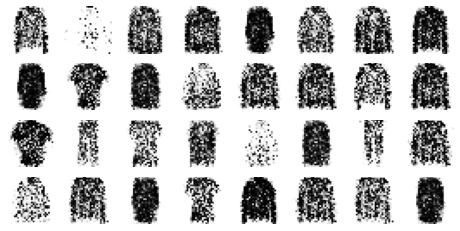

Epoch 2/5


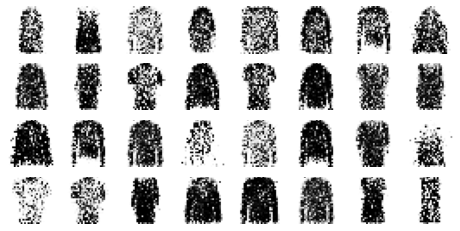

Epoch 3/5


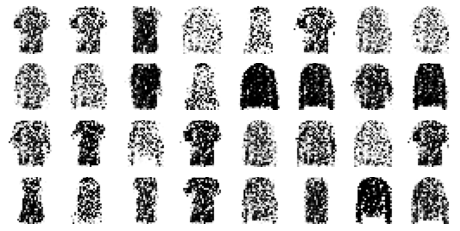

Epoch 4/5


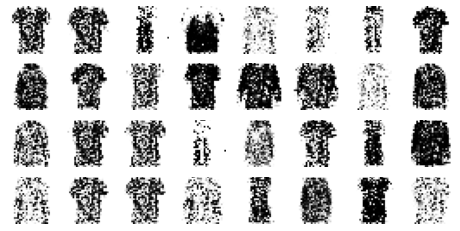

Epoch 5/5


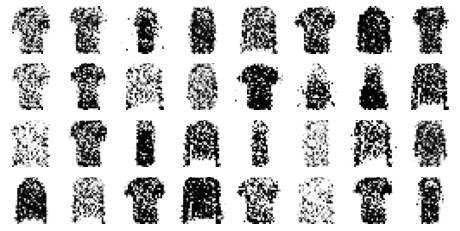

In [10]:
# Step 4. Train the model
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

train_gan(gan, dataset, batch_size, codings_size, n_epochs=5)

### Save Imges

In [5]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(".", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Plot multiple images

In [6]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

### Step 5. Generate Images

Saving figure gan_generated_images_plot


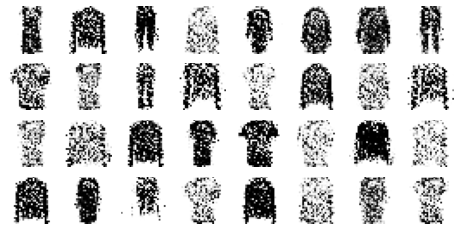

In [12]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)